In [82]:
using CSV
using DataFrames
using MLJ
using Plots
using Statistics
using Random
using StatsPlots

## Functions

In [6]:
"""
`removeByMax(df,threshold)`
    
Returns column names from DataFrame `df` where the maximum value is smaller or equal to `threshold`.
"""
function removeByMax(df, threshold)
   zero_col = String[]
    for i in names(df)
        if (maximum(df[:, i]) <= threshold)
            push!(zero_col, i)
        end
    end
    return zero_col
end

removeByMax

In [7]:
"""
`getGenus(df)`

Returns relative abundance Dataframe, where only genus level columns from `df` are kept.
"""
function getGenus(df)
    genus = names((df), x -> contains(x, "g__") && !contains(x, "s__"))
    splits = split.(genus, "|")
    
    G = copy(df)
    G = G[:,genus]
    
    genusnames = Symbol[]
    for i in 1:length(splits)
        push!(genusnames, Symbol(strip(splits[i][6], ['g','_','_']))) 
    end
    DataFrames.rename!(G, Symbol.(genusnames));
    return G
end

getGenus

In [8]:
"""
`orderByMax(df,n)`

Returns the dataframe `df` with only the top `n` columns when ordered by the maximum value.
"""
function orderByMax(df,n)
    rdf = DataFrame(Genus=String[],Max=Float64[])
    for i in names(df)
        push!(rdf,[i maximum(df[:,i])])
    end
    rdf = sort(rdf,:Max, rev=true)[1:n,:]
    c_names = Symbol.(rdf[:,1])
    return select(df,c_names)
end

orderByMax

## Loading the dataset

In [10]:
# data available at: https://www.kaggle.com/datasets/antaresnyc/human-metagenomics

abundance_df = CSV.read("abundance.csv", DataFrame)
first(abundance_df, 5)

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country
,String,String31,String31,String31,String31,String7,String7,String15
1,Candela_Africa,H10,h10,stool,n,40,female,tanzania
2,Candela_Africa,H11,h11,stool,n,29,female,tanzania
3,Candela_Africa,H12,h12,stool,n,8,female,tanzania
4,Candela_Africa,H13,h13,stool,n,34,male,tanzania
5,Candela_Africa,H14,h14,stool,n,30,male,tanzania


In [13]:
size(abundance_df)

(3610, 3513)

In [15]:
gd = combine(groupby(abundance_df, [:dataset_name, :disease]), nrow => :count);

In [17]:
print(gd)

40×3 DataFrame
 Row │ dataset_name                       disease                     count 
     │ String                             String31                    Int64 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Candela_Africa                     n                              38
   2 │ Chatelier_gut_obesity              n                              25
   3 │ Chatelier_gut_obesity              obesity                       164
   4 │ Chatelier_gut_obesity              leaness                        89
   5 │ doyle_bt2                          nd                            458
   6 │ hmp                                n                             762
   7 │ hmpii                              n                             219
   8 │ Loman2013_EcoliOutbreak_DNA_HiSeq  stec2-positive                 43
   9 │ Loman2013_EcoliOutbreak_DNA_HiSeq   -                              1
  10 │ Loman2013_EcoliOutbreak_DNA_MiSeq  stec2-positive              

## Taking only the cirrhosis data

In [19]:
cirrhosis = subset(abundance_df, :dataset_name => ByRow(==("Quin_gut_liver_cirrhosis")));
first(cirrhosis, 3)

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender
,String,String31,String31,String31,String31,String7,String7
1,Quin_gut_liver_cirrhosis,HD-10,hd-10,stool,n,40,female
2,Quin_gut_liver_cirrhosis,HD-11,hd-11,stool,n,38,female
3,Quin_gut_liver_cirrhosis,HD-12,hd-12,stool,n,40,male


In [65]:
xd = combine(groupby(cirrhosis, :disease), nrow => :count)

,disease,count
,String31,Int64
1,n,114
2,cirrhosis,118


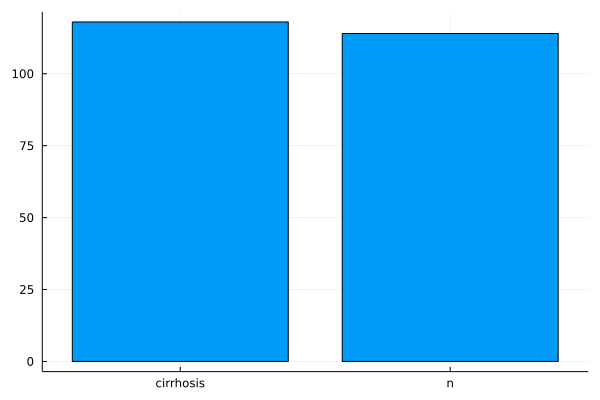

In [71]:
plot(countmap(c_genus.disease), seriestype=:bar, label = false)

## Separating Metadata and Species Abundance

In [21]:
c_meta = cirrhosis[:, Between(begin, "group")]
c_species = cirrhosis[:, Between("k__Archaea", end)];

In [22]:
first(c_species, 3)

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0


In [23]:
first(c_meta, 10)

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender
,String,String31,String31,String31,String31,String7,String7
1,Quin_gut_liver_cirrhosis,HD-10,hd-10,stool,n,40,female
2,Quin_gut_liver_cirrhosis,HD-11,hd-11,stool,n,38,female
3,Quin_gut_liver_cirrhosis,HD-12,hd-12,stool,n,40,male
4,Quin_gut_liver_cirrhosis,HD-13,hd-13,stool,n,56,female
5,Quin_gut_liver_cirrhosis,HD-14,hd-14,stool,n,51,male
6,Quin_gut_liver_cirrhosis,HD-15,hd-15,stool,n,56,male
7,Quin_gut_liver_cirrhosis,HD-16,hd-16,stool,n,41,female
8,Quin_gut_liver_cirrhosis,HD-17,hd-17,stool,n,46,male
9,Quin_gut_liver_cirrhosis,HD-18,hd-18,stool,n,43,male


## Removing missing data

In [24]:
c_metaShort = c_meta[:, any.(i -> (i!=("nd") && i!=("-")), eachcol(c_meta))]
first(c_metaShort, 3)

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender
,String,String31,String31,String31,String31,String7,String7
1,Quin_gut_liver_cirrhosis,HD-10,hd-10,stool,n,40,female
2,Quin_gut_liver_cirrhosis,HD-11,hd-11,stool,n,38,female
3,Quin_gut_liver_cirrhosis,HD-12,hd-12,stool,n,40,male


In [25]:
zero_col = removeByMax(c_species, 0)
c_speciesFull = copy(c_species[:,Not(zero_col)])
first(c_speciesFull,3)

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0


## Keeping only the genus

In [26]:
c_genus = getGenus(c_speciesFull)
first(c_genus,3)

,Methanobrevibacter,Methanosphaera,Actinomyces,Rothia,Bifidobacterium,Gardnerella
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.11273,0.0
3,0.0,0.0,0.0,0.0,0.05692,0.0


In [27]:
size(c_genus)

(232, 186)

In [28]:
c_genus.disease = cirrhosis.disease;
size(c_genus)

(232, 187)

## Calculating Shannon Index Alpha Diversity

In [79]:
case = subset(c_genus, :disease => ByRow(==("cirrhosis")))
control = subset(c_genus, :disease => ByRow(==("n")));

In [74]:
fullCase = subset(c_genus,:disease => ByRow(==("cirrhosis")))
fullControl = subset(c_genus,:disease => ByRow(==("n")));

fullCaseM = Matrix(fullCase[:,Not(:disease)])
fullControlM = Matrix(fullControl[:,Not(:disease)]);

In [77]:
using Diversity.Ecology

caseDiversity = shannon(fullCaseM').diversity
controlDiversity = shannon(fullControlM').diversity;

┌ Warning: Abundances not normalised to 1, correcting...
└ @ Diversity /home/lucas/.julia/packages/Diversity/JTLSo/src/Metacommunity.jl:115
┌ Warning: Abundances not normalised to 1, correcting...
└ @ Diversity /home/lucas/.julia/packages/Diversity/JTLSo/src/Metacommunity.jl:115


In [80]:
B = DataFrame(diversity = vcat(caseDiversity,controlDiversity),tipo = vcat(case.disease,control.disease));

## Diversity boxplot of the labels

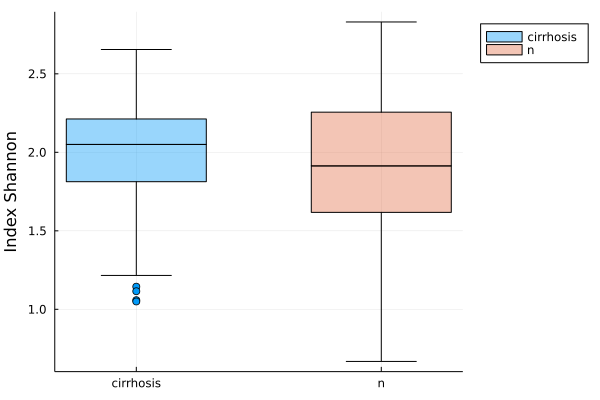

In [83]:
StatsPlots.boxplot(B.tipo, B.diversity, fillalpha=0.4, group=B.tipo, 
    legendposition=:outertopright, ylabel="Index Shannon")

## Train and Test split

In [48]:
y, X = unpack(c_genus, ==(:disease), colname->true);
yc = coerce(y, OrderedFactor)
first(yc, 10);

In [49]:
Random.seed!(123)
train, test = partition(collect(eachindex(yc)), 0.7, shuffle = true, rng = 223);

## Keeping only the relevant features using hypothesis test.

In [51]:
caseT = case[:,Not(:disease)]
controlT = control[:,Not(:disease)];

genus_d = String[]
for name in names(X)
    pvalor = pvalue(OneSampleTTest(caseT[1:114, name], controlT[:, name]))
    if (pvalor <= 0.05)
       push!(genus_d, name) 
    end
end

X_filt = copy(X[:, genus_d]);
print(names(X_filt))

["Actinomyces", "Rothia", "Adlercreutzia", "Atopobium", "Olsenella", "Bacteroides", "Bacteroidales_noname", "Barnesiella", "Coprobacter", "Odoribacter", "Alloprevotella", "Paraprevotella", "Alistipes", "Granulicatella", "Lactobacillus", "Weissella", "Streptococcus", "Clostridium", "Clostridiales_noname", "Eubacterium", "Blautia", "Coprococcus", "Dorea", "Roseburia", "Oscillibacter", "Anaerotruncus", "Faecalibacterium", "Ruminococcus", "Subdoligranulum", "Coprobacillus", "Solobacterium", "Megasphaera", "Veillonella", "Leptotrichiaceae_unclassified", "Burkholderiales_noname", "Oxalobacter", "Neisseria", "Bilophila", "Desulfovibrio", "Campylobacter", "Citrobacter", "Escherichia", "Klebsiella", "Aggregatibacter", "Haemophilus", "Butyricimonas", "Gemella", "Staphylococcus", "Butyricicoccus", "Clostridiales_Family_XIII_Incertae_Sedis_unclassified", "Oribacterium", "Selenomonas", "Burkholderia", "Pantoea", "Raoultella", "Actinobacillus", "Leptotrichia", "Eikenella"]

In [43]:
first(X_filt, 3)

,Actinomyces,Rothia,Adlercreutzia,Atopobium,Olsenella,Bacteroides,Bacteroidales_noname
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.02685,0.0,0.0,27.0561,0.42994
2,0.0,0.0,0.25012,0.0,0.0,22.9985,1.8049
3,0.0,0.0,0.14068,0.0,0.0,16.7792,0.74253


## Loading the SGDC model

In [44]:
SGDC = @load SGDClassifier pkg = ScikitLearn
sgdc = SGDC()

import MLJScikitLearnInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/lucas/.julia/packages/MLJModels/lDzCR/src/loading.jl:168


SGDClassifier(
  loss = "hinge", 
  penalty = "l2", 
  alpha = 0.0001, 
  l1_ratio = 0.15, 
  fit_intercept = true, 
  max_iter = 1000, 
  tol = 0.001, 
  shuffle = true, 
  verbose = 0, 
  epsilon = 0.1, 
  n_jobs = nothing, 
  random_state = nothing, 
  learning_rate = "optimal", 
  eta0 = 0.0, 
  power_t = 0.5, 
  early_stopping = false, 
  validation_fraction = 0.1, 
  n_iter_no_change = 5, 
  class_weight = nothing, 
  warm_start = false, 
  average = false)

## Training steps

In [53]:
Random.seed!(123)
r = [range(sgdc, :loss, values = ["log_loss", "hinge"]),
range(sgdc, :penalty, values = ["l2", "l1"]),
range(sgdc, :alpha, lower = 1e-3, upper=1e-1, scale=:log10)];

self_tuning_sgdc = TunedModel(model = sgdc, range = r, tuning = Grid(resolution = 5), 
resampling = StratifiedCV(nfolds = 6, rng = 123), measure = MisclassificationRate());

sgdc_tuned_mach = machine(self_tuning_sgdc, X_filt, yc)

Machine trained 0 times; does not cache data
  model: DeterministicTunedModel(model = SGDClassifier(loss = hinge, …), …)
  args: 
    1:	Source @966 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @498 ⏎ `AbstractVector{OrderedFactor{2}}`


In [54]:
Random.seed!(123);
evalu_tune = evaluate!(sgdc_tuned_mach, 
    resampling = CV(nfolds=5, rng=123),
    measures = [accuracy, f1score],
    rows = train,
    repeats = 5)

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /home/lucas/.julia/packages/MLJBase/rQDaq/src/resampling.jl:599
/home/lucas/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
Evaluating over 25 folds:  28%[=======>                 ]  ETA: 0:01:47/home/lucas/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
Evaluating over 25 folds:  32%[========>                ]  ETA: 0:01:30/home/lucas/.julia/conda/3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌──────────────────┬───────────┬─────────────┬─────────┬────────────────────────
│ measure          │ operation │ measurement │ 1.96*SE │ per_fold              ⋯
├──────────────────┼───────────┼─────────────┼─────────┼────────────────────────
│ Accuracy()       │ predict   │ 0.821       │ 0.0285  │ [0.879, 0.697, 0.969, ⋯
│ FScore(          │ predict   │ 0.805       │ 0.0349  │ [0.889, 0.667, 0.971, ⋯
│   β = 1.0,       │           │             │         │                       ⋯
│   rev = nothing) │           │             │         │                       ⋯
└──────────────────┴───────────┴─────────────┴─────────┴────────────────────────
                                                                1 column omitted


In [55]:
fitted_params(sgdc_tuned_mach).best_model

SGDClassifier(
  loss = "hinge", 
  penalty = "l1", 
  alpha = 0.001, 
  l1_ratio = 0.15, 
  fit_intercept = true, 
  max_iter = 1000, 
  tol = 0.001, 
  shuffle = true, 
  verbose = 0, 
  epsilon = 0.1, 
  n_jobs = nothing, 
  random_state = nothing, 
  learning_rate = "optimal", 
  eta0 = 0.0, 
  power_t = 0.5, 
  early_stopping = false, 
  validation_fraction = 0.1, 
  n_iter_no_change = 5, 
  class_weight = nothing, 
  warm_start = false, 
  average = false)

In [60]:
feature_power = DataFrame(genus = names(X_filt), 
power = vec(fitted_params(sgdc_tuned_mach).best_fitted_params.coef))

sort!(feature_power, [:power], rev = true);

## Results

### Most relevant features

In [61]:
first(feature_power, 10)

,genus,power
,String,Float64
1,Paraprevotella,90.1465
2,Bacteroidales_noname,65.1253
3,Bilophila,44.0188
4,Roseburia,42.9609
5,Coprococcus,40.2624
6,Barnesiella,15.4289
7,Burkholderiales_noname,12.8112
8,Eubacterium,9.89777
9,Dorea,8.81435


In [62]:
yhat = MLJ.predict(sgdc_tuned_mach, rows = test);
print(
    "Measurements:\n",
    "  f1 score: ", f1score(yhat, yc[test]), "\n",
    "  accuracy:   ", accuracy(yhat, yc[test]), "\n"
)
ConfusionMatrix()(yhat, yc[test])

Measurements:
  f1 score: 0.7419354838709677
  accuracy:   0.7714285714285715


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │  cirrhosis  │      n      │
├─────────────┼─────────────┼─────────────┤
│  cirrhosis  │     31      │     12      │
├─────────────┼─────────────┼─────────────┤
│      n      │      4      │     23      │
└─────────────┴─────────────┴─────────────┘
